In [2]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
x_train = np.load('gdrive/My Drive/dataset/dataset2/trainX.npy')
y_train = np.load('gdrive/My Drive/dataset/dataset2/trainy.npy')
x_test = np.load('gdrive/My Drive/dataset/dataset2/testX.npy')
y_test = np.load('gdrive/My Drive/dataset/dataset2/testy.npy')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Mounted at /content/drive
Mounted at /content/gdrive
(44339, 128, 6) (44339, 20) (4936, 128, 6) (4936, 20)


In [3]:
from numpy import save, load
from pandas import read_csv
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras import Model
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense,Activation
from keras.models import Input, Model
from keras.layers import LSTM, Conv1D, concatenate,GlobalMaxPooling1D,GlobalAveragePooling1D,TimeDistributed, MaxPooling1D
import tensorflow as tf
import numpy as np
import keras.backend as K
import keras.layers
from keras import optimizers
from keras.layers import Activation, Lambda
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from typing import List, Tuple

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
x_train = np.load('gdrive/My Drive/dataset/dataset2/trainX.npy')
y_train = np.load('gdrive/My Drive/dataset/dataset2/trainy.npy')
x_test = np.load('gdrive/My Drive/dataset/dataset2/testX.npy')
y_test = np.load('gdrive/My Drive/dataset/dataset2/testy.npy')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Mounted at /content/drive
Mounted at /content/gdrive
(44339, 128, 6) (44339, 20) (4936, 128, 6) (4936, 20)


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [6]:
def channel_normalization(x):
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out

def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding,
                  name=name + '_dilated_conv_%d_tanh_s%d' % (i, s))(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x

In [7]:
class TCN:

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding
        

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' paddings are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        if self.dilations is None:
            self.dilations = [1, 2, 4, 8, 16, 32]
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i in self.dilations:
                x, skip_out = residual_block(x, s, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x

In [8]:
input_shape = x_train.shape[1:]
input = Input(shape=x_train.shape[1:])
x = SpatialDropout1D(0.2)(input)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc1')(x)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc2')(x)
max_pool = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(max_pool)
x = Dropout(0.2)(x)
output = Dense(20, activation="softmax")(x)    
model = Model(inputs=input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 6)]     0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 128, 6)      0           ['input_1[0][0]']                
 out1D)                                                                                           
                                                                                                  
 tnc1_initial_conv (Conv1D)     (None, 128, 128)     896         ['spatial_dropout1d[0][0]']      
                                                                                                  
 tnc1_dilated_conv_1_tanh_s0 (C  (None, 128, 128)    49280       ['tnc1_initial_conv[0][0]']  

In [ ]:
history = model.fit(x_train, y_train, epochs=200, verbose=True, validation_data=(x_validation, y_validation), batch_size=128,callbacks=callbacks)

Epoch 1/200
278/278 [==============================] - 49s 160ms/step - loss: 0.7717 - accuracy: 0.7781 - val_loss: 0.1259 - val_accuracy: 0.9646
Epoch 2/200
278/278 [==============================] - 44s 159ms/step - loss: 0.1878 - accuracy: 0.9484 - val_loss: 0.0907 - val_accuracy: 0.9755
Epoch 3/200
278/278 [==============================] - 44s 159ms/step - loss: 0.1260 - accuracy: 0.9649 - val_loss: 0.0687 - val_accuracy: 0.9811
Epoch 4/200
278/278 [==============================] - 44s 159ms/step - loss: 0.1042 - accuracy: 0.9702 - val_loss: 0.0704 - val_accuracy: 0.9798
Epoch 5/200
278/278 [==============================] - 44s 158ms/step - loss: 0.0830 - accuracy: 0.9763 - val_loss: 0.0547 - val_accuracy: 0.9849
Epoch 6/200
278/278 [==============================] - 45s 161ms/step - loss: 0.0723 - accuracy: 0.9794 - val_loss: 0.0431 - val_accuracy: 0.9883
Epoch 7/200
164/278 [================>.............] - ETA: 17s - loss: 0.0691 - accuracy: 0.9801

In [10]:
loss, accuracy = model.evaluate(x_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9905
Testing Accuracy: 0.9688


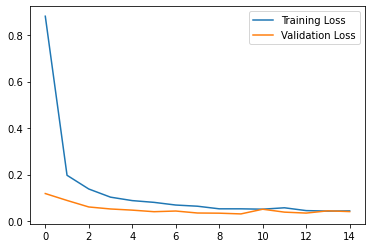

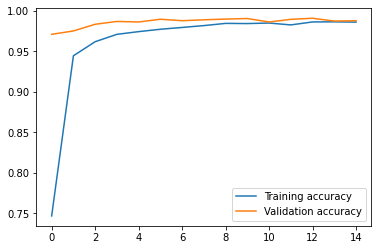

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()

>knn -101.019 (7.161)
>cart -149.067 (10.711)
>svm -162.419 (12.565)


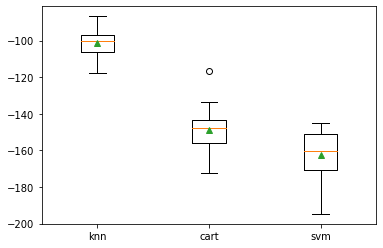

In [21]:

# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()